In [1]:
# ================================================================
# Bachelor Thesis — Fairness in Toxic Comment Classification
# ---------------------------------------------------------------
# Notebook: base_model_training_and_evaluation.ipynb
# Author: Philipp Stocker
# Created: 14.11.2025
# Purpose: TODO: fill purpose
# ================================================================

# --- Basic setup ---
import os
import sys
import warnings
warnings.filterwarnings("ignore")  # keep output clean for reports

# Automatically add project root to path so src/ modules are importable
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Standard imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from src.modeling import train_lr_tfidf
from src.modeling import predict_with_model
from src.modeling import extract_feature_and_label_arrays
from src.modeling import find_best_threshold

from src.metrics import compute_overall_metrics

from src.visualization import (
    plot_performance_bar,
    plot_roc_curve,
    plot_pr_curve,
    plot_confusion_matrix,
)

# --- "Global variables" ---
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")

IDENTITY_COLUMNS = ["male", "female", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "transgender", "other_gender", "other_sexual_orientation"]

print("✅ Environment ready")


✅ Environment ready


Load feature and label arrays

In [3]:
x_train, y_train = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "train_tfidf_bundle.joblib")))
x_val, y_val = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "val_tfidf_bundle.joblib")))
x_test, y_test = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "test_tfidf_bundle.joblib")))

BASE MODEL TRAINING

Train base model including hyperparameter tuning and calibration

In [ ]:
# Train base model: Logistic Regression with TF-IDF features (per default with hyperparameter tuning and calibration)
base_models = train_lr_tfidf(
    x_train=x_train,
    y_train=y_train
)

# Save trained base models
joblib.dump(base_models, project_root + "/models/tfidf_base_models.joblib")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  29.8s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  30.4s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  29.0s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  29.9s
[CV] END C=0.1, class_weight=None, penalty=l1, solver=liblinear; total time=  27.9s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  16.8s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  18.4s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  19.4s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  18.7s
[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=  17.5s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=  40.8s
[CV] END C

['c:\\Users\\phili\\OneDrive\\Dokumente\\Uni\\Kurse\\7. Semester\\Bachelorarbeit\\BA_Arbeitsmappe\\BachelorThesis_BiasInToxicCommentClassification/models/tfidf_base_models.joblib']

BASE MODEL EVALUATION

Load base models for further evaluation

In [4]:
base_models = joblib.load(project_root + "/models/tfidf_base_models.joblib")

Calculate best threshold based on f1 score

In [5]:
y_val_proba = base_models["model"].predict_proba(x_val)[:, 1]

threshold = find_best_threshold(y_val, y_val_proba)

Best threshold: 0.25 with F1-score: 0.6467


Conduct prediction on test dataset and print result

In [6]:
y_test_proba, y_test_pred = predict_with_model(base_models["model"], x_test, threshold=threshold)

# Calculate and print number of toxic and non-toxic comments in test set
count_toxic = np.sum(y_test_pred)
count_nontoxic = len(y_test_pred) - count_toxic
print(f"Number of toxic comments: {count_toxic}")
print(f"Number of non-toxic comments: {count_nontoxic}")    

Number of toxic comments: 22661
Number of non-toxic comments: 248070


Optional: conduct prediction on test dataset with uncalibrated model for comparision

In [6]:
if base_models["uncalibrated_model"] is not None:
    y_test_proba_uncalibrated, y_test_pred_uncalibrated = predict_with_model(base_models["uncalibrated_model"], x_test, threshold=threshold)
    count_toxic_uncalibrated = np.sum(y_test_pred_uncalibrated)
    count_nontoxic_uncalibrated = len(y_test_pred_uncalibrated) - count_toxic_uncalibrated
    print(f"Number of toxic comments (uncalibrated): {count_toxic_uncalibrated}")
    print(f"Number of non-toxic comments (uncalibrated): {count_nontoxic_uncalibrated}")

Number of toxic comments (uncalibrated): 70445
Number of non-toxic comments (uncalibrated): 200286


BASE MODEL PERFORMANCE METRICS

Calculate performance metrics

In [7]:
base_model_overall_metrics = compute_overall_metrics(y_test, y_test_pred, y_test_proba)

print("Overall metrics for base model:")
print(base_model_overall_metrics)

Overall metrics for base model:
{'accuracy': 0.94105588203789, 'precision': 0.6256122854242973, 'recall': 0.6547965451942174, 'f1_score': 0.6398718180176928, 'roc_auc': 0.9483893764015319, 'pr_auc': 0.6974232009378413}


Visualize performance metrics

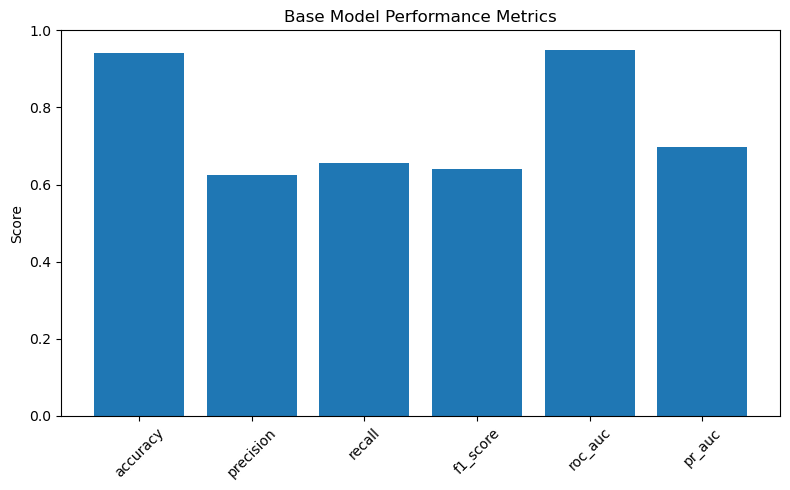

In [8]:
# Plot performance bars
plot_performance_bar(base_model_overall_metrics, title="Base Model Performance Metrics")

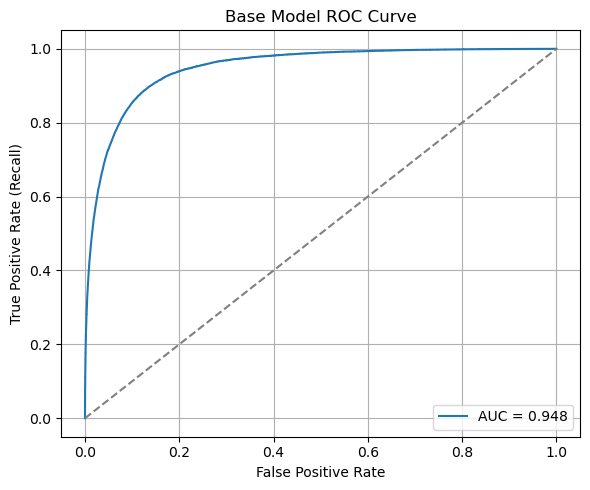

In [9]:
# Plot ROC curve
plot_roc_curve(y_test, y_test_proba, title="Base Model ROC Curve")

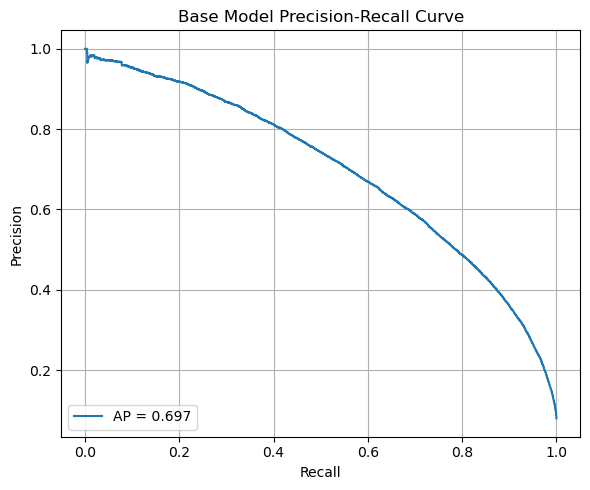

In [10]:
# Plot PR curve
plot_pr_curve(y_test, y_test_proba, title="Base Model Precision-Recall Curve")

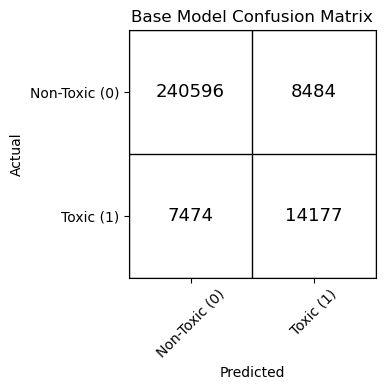

In [8]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred, title="Base Model Confusion Matrix")